This notebook creates the table of RTC data covering a subset of the DIST-HLS validation sites over 2022-2023 (see the previous directory of notebooks for how this subset was generated).

In [56]:
import concurrent.futures
import urllib3
from functools import lru_cache
from dotenv import dotenv_values
from elasticsearch import Elasticsearch, RequestsHttpConnection
from elasticsearch_dsl import Q, Search
from tqdm import tqdm
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip, to_geojson_gzip

In [2]:
urllib3.disable_warnings()


@lru_cache
def get_search_client():
    config = dotenv_values()
    ES_USERNAME = config["ES_USERNAME"]
    ES_PASSWORD = config["ES_PASSWORD"]
    GRQ_URL = "https://100.104.62.10/grq_es/"
    # See: https://github.com/nasa/opera-sds-pcm/
    # blob/81ccb1bd40981588754a438b4dd0eb1506301276/tools/ops/cnm_check.py#L40-L47
    grq_client = Elasticsearch(
        GRQ_URL,
        http_auth=(ES_USERNAME, ES_PASSWORD),
        verify_certs=False,
        use_ssl=True,
        connection_class=RequestsHttpConnection,
        read_timeout=50000,
        terminate_after=2500,
        ssl_show_warn=False,
    )
    search = Search(using=grq_client, index="grq_v1.0_l2_rtc_s1-2024.04")

    if not grq_client.ping():
        raise ValueError(
            "Either JPL username/password is wrong or not connected to VPN"
        )

    return search


def get_rtc_es_docs_from_slc_id(slc_id: str, target_rtc_version="1.0.1") -> list[dict]:
    "Version is determined by latest here: https://github.com/opera-adt/RTC/releases"
    search = get_search_client()
    q_qs = Q(
        "query_string", query=f'"{slc_id}"', default_field="metadata.input_granule_id"
    )

    query = search.query(q_qs)
    total = query.count()
    # using this: https://github.com/elastic/elasticsearch-dsl-py/issues/737
    query = query[0:total]
    resp = query.execute()

    hits = list(resp.hits)

    def filter_by_version(hit):
        return hit.metadata.sas_version == target_rtc_version

    hits_f = list(filter(filter_by_version, hits))

    data = [hit.to_dict() for hit in hits_f]
    for hit in data:
        hit['bursts_per_slc'] = len(data)
    return data

In [3]:
df_slcs = pd.read_csv('../3_dist_sites/slcs_for_processing.csv.zip')
df_slcs.head()

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,sensor,groupID,pgeVersion,fileName,beamModeType,site_id,jpl_burst_id,geometry,date_acquired_str,dist_from_site_to_slc_centroid
0,4.4481,20.2077,2020-10-06 04:24:27+00:00,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-06 04:24:02+00:00,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,...,C-SAR,S1B_IWDV_0576_0582_023687_036,3.31,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,IW,4,t036_076228_iw3,"POLYGON ((21.16021 3.45474, 21.475183 4.977134...",2020-10-06,0.883877
1,4.4236,20.1938,2020-10-12 04:25:12+00:00,S1A_IW_SLC__1SDV_20201012T042442_20201012T0425...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2020-10-12 04:24:42+00:00,S1A_IW_SLC__1SDV_20201012T042442_20201012T0425...,...,C-SAR,S1A_IWDV_0577_0582_034758_036,3.31,S1A_IW_SLC__1SDV_20201012T042442_20201012T0425...,IW,4,t036_076228_iw3,"POLYGON ((21.119974 3.288932, 21.493208 5.0927...",2020-10-12,0.874183
2,4.4486,20.2086,2020-10-18 04:24:27+00:00,S1B_IW_SLC__1SDV_20201018T042402_20201018T0424...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-18 04:24:02+00:00,S1B_IW_SLC__1SDV_20201018T042402_20201018T0424...,...,C-SAR,S1B_IWDV_0576_0582_023862_036,3.31,S1B_IW_SLC__1SDV_20201018T042402_20201018T0424...,IW,4,t036_076228_iw3,"POLYGON ((21.161163 3.455358, 21.476076 4.9775...",2020-10-18,0.884746
3,4.4239,20.1944,2020-10-24 04:25:12+00:00,S1A_IW_SLC__1SDV_20201024T042442_20201024T0425...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2020-10-24 04:24:42+00:00,S1A_IW_SLC__1SDV_20201024T042442_20201024T0425...,...,C-SAR,S1A_IWDV_0577_0583_034933_036,3.31,S1A_IW_SLC__1SDV_20201024T042442_20201024T0425...,IW,4,t036_076228_iw3,"POLYGON ((21.120504 3.2891, 21.493803 5.093129...",2020-10-24,0.874706
4,4.4484,20.2082,2020-10-30 04:24:28+00:00,S1B_IW_SLC__1SDV_20201030T042402_20201030T0424...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-30 04:24:02+00:00,S1B_IW_SLC__1SDV_20201030T042402_20201030T0424...,...,C-SAR,S1B_IWDV_0576_0582_024037_036,3.31,S1B_IW_SLC__1SDV_20201030T042402_20201030T0424...,IW,4,t036_076228_iw3,"POLYGON ((21.160759 3.455127, 21.475697 4.9774...",2020-10-30,0.884370


In [4]:
slc_ids = [slc_id.replace('.zip', '') for slc_id in df_slcs.fileName.unique()]
len(slc_ids), slc_ids[0]

(8703, 'S1B_IW_SLC__1SDV_20201006T042402_20201006T042427_023687_02D024_8307')

In [9]:
md = get_rtc_es_docs_from_slc_id(slc_ids[0])
md[0]['id']

'OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0'

In [10]:
def format_data(metadata: dict)-> dict:
    return dict(rtc_s1_id=metadata['id'],
                input_slc_id=metadata['metadata']['input_granule_id'],
                jpl_burst_id=metadata['metadata']['Files'][0]['burst_id'],
                bursts_per_slc_input=metadata['bursts_per_slc'],
                rtc_s1_vv_url=[url for url in metadata['metadata']['product_urls'] if '_VV.tif' in url][0],
                rtc_s1_vh_url=[url for url in metadata['metadata']['product_urls'] if '_VV.tif' in url][0],
                rtc_s1_h5_url=[url for url in metadata['metadata']['product_urls'] if '.h5' == url[-3:]][0])

format_data(md[3])

{'rtc_s1_id': 'OPERA_L2_RTC-S1_T036-076229-IW3_20201006T042416Z_20240426T220152Z_S1B_30_v1.0',
 'input_slc_id': 'S1B_IW_SLC__1SDV_20201006T042402_20201006T042427_023687_02D024_8307',
 'jpl_burst_id': 'T036-076229-IW3',
 'bursts_per_slc_input': 25,
 'rtc_s1_vv_url': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T036-076229-IW3_20201006T042416Z_20240426T220152Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T036-076229-IW3_20201006T042416Z_20240426T220152Z_S1B_30_v1.0_VV.tif',
 'rtc_s1_vh_url': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T036-076229-IW3_20201006T042416Z_20240426T220152Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T036-076229-IW3_20201006T042416Z_20240426T220152Z_S1B_30_v1.0_VV.tif',
 'rtc_s1_h5_url': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T036-076229-IW3_20201006T042416Z_20240426T220152Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T036-076229-IW3_20201006T042416Z_20240426T220152Z_S1B_30_v1.0.h5

In [11]:
with concurrent.futures.ThreadPoolExecutor(max_workers=50) as executor:
    docs_raw = list(tqdm(executor.map(get_rtc_es_docs_from_slc_id, slc_ids[:]), total=len(slc_ids)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8703/8703 [06:05<00:00, 23.81it/s]


In [12]:
rtc_metadata = [format_data(md) for docs_lst in docs_raw for md in docs_lst]
rtc_metadata[:2]

[{'rtc_s1_id': 'OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0',
  'input_slc_id': 'S1B_IW_SLC__1SDV_20201006T042402_20201006T042427_023687_02D024_8307',
  'jpl_burst_id': 'T036-076225-IW1',
  'bursts_per_slc_input': 25,
  'rtc_s1_vv_url': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0_VV.tif',
  'rtc_s1_vh_url': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0_VV.tif',
  'rtc_s1_h5_url': 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_

In [13]:
df_rtc = pd.DataFrame(rtc_metadata)
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url
0,OPERA_L2_RTC-S1_T036-076225-IW1_20201006T04240...,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,T036-076225-IW1,25,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
1,OPERA_L2_RTC-S1_T036-076231-IW2_20201006T04242...,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,T036-076231-IW2,25,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
2,OPERA_L2_RTC-S1_T036-076229-IW1_20201006T04241...,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,T036-076229-IW1,25,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
3,OPERA_L2_RTC-S1_T036-076229-IW3_20201006T04241...,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,T036-076229-IW3,25,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
4,OPERA_L2_RTC-S1_T036-076232-IW3_20201006T04242...,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,T036-076232-IW3,25,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...


In [58]:
df_rtc['acq_datetime'] = pd.to_datetime(df_rtc.input_slc_id.map(lambda slc_id: slc_id.split('_')[5])).astype(str)
df_rtc.sort_values(by=['jpl_burst_id', 'acq_datetime'], inplace=True)
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
26537,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
26590,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
26642,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
26700,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
26752,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [59]:
compression_options = dict(method='zip', archive_name=f'rtc_s1_table.json')
df_rtc.to_json('rtc_s1_table.json.zip', compression=compression_options, index=False, indent=2, orient='records')

In [60]:
df_burst = read_geojson_gzip('../1_visualize_rtc_time_series/opera_burst_ids.geojson.zip')
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


In [61]:
burst_ids_jpl[:2]

['t036_076225_iw1', 't036_076231_iw2']

<Axes: >

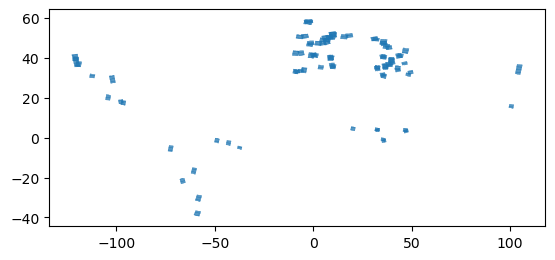

In [62]:
burst_ids_jpl = [burst_id.lower().replace('-', '_') for burst_id in df_rtc.jpl_burst_id.unique()]
df_burst_subset = df_burst[df_burst.burst_id_jpl.isin(burst_ids_jpl)].reset_index(drop=True)
df_burst_subset['jpl_burst_id'] = df_burst_subset.burst_id_jpl.map(lambda burst_id: burst_id.lower().replace('-', '_'))
df_burst_subset = df_burst_subset[['jpl_burst_id', 'orbit_pass', 'geometry']].copy()
df_burst_subset.plot()

In [63]:
df_burst_subset.head()

,jpl_burst_id,orbit_pass,geometry
0,t005_008688_iw2,ASCENDING,"POLYGON ((-97.90103 16.86358, -97.06559 17.014..."
1,t005_008688_iw3,ASCENDING,"POLYGON ((-97.09889 17.06678, -96.35903 17.196..."
2,t005_008689_iw1,ASCENDING,"POLYGON ((-98.69437 16.82087, -97.89903 16.966..."
3,t005_008689_iw2,ASCENDING,"POLYGON ((-97.93485 17.03023, -97.09864 17.180..."
4,t005_008689_iw3,ASCENDING,"POLYGON ((-97.13196 17.23328, -96.39139 17.362..."


In [65]:
to_geojson_gzip(df_burst_subset, 'burst_extent_subset.geojson.zip')

'burst_extent_subset.geojson.zip'